In [297]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

from scipy import sparse
from scipy.sparse import linalg

from matplotlib import cm
from matplotlib.ticker import LinearLocator
import logging

I have used the my attmpt of class from step 2

In [298]:
class MESH:
    def __init__(self,mat_layout,src_layout,width,n_ref,verbose):
        self.logger=logging.getLogger(__name__)
        logging.basicConfig(format="%(levelname)s: %(message)s")
        self.verbose=verbose

        if self.verbose:
            self.logger.setLevel(logging.DEBUG)
            self.logger.debug("Debugging Logger has been turned on.")
        else:
            self.logger.setLevel(logging.INFO)
            self.logger.info("Info logger has been turned on.")

        
        if not(len(mat_layout)==len(src_layout)==len(width)==len(n_ref)):

            self.logger.debug(f"Length  arrays-\n mat_layout:{len(mat_layout)},\nsrc_layout:{len(src_layout)}\nwidth:{len(width)}\nn_ref:{len(n_ref)} ")
            raise ValueError("The sizes of the inputs are not equal. Please, double check.")
        
        
        self.mat_layout=mat_layout
        self.src_layout=src_layout
        self.width=width
        self.n_ref=n_ref
    

        self.nzones=len(self.n_ref)
        self.n_cells=int(sum(self.n_ref))
        
        for ind in range(self.nzones):
            if not (isinstance(self.mat_layout[ind],int)==isinstance(self.src_layout[ind],int)==isinstance(self.width[ind],float)==isinstance(self.n_ref[ind],np.int64)):
                raise ValueError("The user provided arrays with type of values that were not asked for.")
            if self.width[ind]==0 or self.n_ref[ind]==0:
                raise ValueError("The width or n_ref should not have any zero element.")
        

        self.interface_boundary=np.union1d(0,np.cumsum(self.width))
        
        self.x=np.zeros(1,dtype=float)
        for i in range(self.nzones):
            self.x=np.union1d(self.x,np.linspace(self.interface_boundary[i],self.interface_boundary[i+1],self.n_ref[i]+1))
        
        

        self.dx=np.diff(self.x)
        self.J=self.dx/2
        self.logger.debug(f"dx:{self.dx}\nJ:{self.J}")
        
        
        self.cell2mat=np.zeros(self.n_cells,dtype=int)
        self.cell2src=np.zeros(self.n_cells,dtype=int)
        
        j=0
        for ind,value in enumerate(self.n_ref):
            for i in range(value):
                
                self.cell2mat[j]=self.mat_layout[ind]
                self.cell2src[j]=self.src_layout[ind]
                j=j+1
        self.logger.debug(f"cell2mat:{self.cell2mat}\ncell2src:{self.cell2src}")
        self.connectivity()
        

    def connectivity(self):

        self.logger.debug("Inside connectivity method")

        self.gn=np.zeros((self.n_cells,2),dtype=int)
        self.gn[0,:]=[0,1]
        for k in range(1,self.n_cells):
            self.gn[k,0]=self.gn[k-1,-1]
            self.gn[k,1]=self.gn[k,0]+1
        self.logger.debug(f"Connectivity matrix:\n{self.gn}")




        
        

    



Assemble System and Apply bc methods are different. For everything else I tried to implement algorithms used by Professor in previous codes.

In [299]:
class FEM_solver:
    def __init__(self,degree,verbose):
        self.degree=degree
        self.verbose=verbose
        self.b,self.dbdx=self.basis()

        self.Kxx,self.M,self.Q=self.compute_elemental_matrices()

    #there's nothing to change what Professor Ragusa has done in step 1
    def basis(self):
        b=[]
        b.append(lambda u: (1-u)/2)
        b.append(lambda u: (1+u)/2)

        dbdx=[]
        dbdx.append(lambda u: -0.5)
        dbdx.append(lambda u: 0.5)

        return b,dbdx
    def compute_elemental_matrices(self):
        [quad_point, weight]=np.polynomial.legendre.leggauss(self.degree)
        local_dofs=len(self.b)
        Kxx=np.zeros((local_dofs,local_dofs))
        M=np.zeros((local_dofs,local_dofs))
        Q=np.zeros(local_dofs)

        for (x,w) in zip(quad_point,weight):
            for i,(el1, d_el1) in enumerate(zip(self.b,self.dbdx)):
                Q[i]+=w*el1(x)
                for j,(el2, d_el2) in enumerate(zip(self.b,self.dbdx)):
                    M[i,j]+=w*el1(x)*el2(x)
                    Kxx[i,j]+=w*d_el1(x)*d_el2(x)
        
        return Kxx,M,Q
    
    def assemble_system(self,mesh,prop,bc):
        self.gn=mesh.gn
        self.A=sparse.lil_matrix((mesh.n_cells+1,mesh.n_cells+1))
        self.rhs=np.zeros(mesh.n_cells+1)
        self.mesh=mesh
        self.prop=prop
        self.bc=bc
        #print(mesh.gn)
        for elem, elem_i in enumerate(self.gn):
            material_id=mesh.cell2mat[elem]
            
            source_id=mesh.cell2src[elem]
            D=prop["D"][material_id]
            
            sigma=prop["sigma"][material_id]
            q=prop['src'][source_id]
            

            self.A[elem_i[0]:elem_i[1]+1,elem_i[0]:elem_i[1]+1]+=D*self.Kxx/mesh.J[elem]+sigma*self.M*mesh.J[elem]
            self.rhs[elem_i[0]:elem_i[1]+1]+=self.Q*mesh.J[elem]*q
        self.A,self.rhs=self.apply_boundary_conditions(self.A.copy(),self.rhs.copy(),self.bc.copy(),mesh.n_cells+1)

        return self.A,self.rhs
    def apply_boundary_conditions(self,A,rhs,bc,n_nodes):
        
        if bc['xmin']['type']=="dirichlet":
            A[0,:]=0
            A[0,0]=1
            rhs[0]=bc['xmin']['value']   
        if bc['xmax']['type']=="dirichlet":
            A[-1,:]=0
            A[-1,-1]=1
            rhs[-1]=bc['xmax']['value']

        if bc['xmin']['type']=="neumann":
            rhs[0]+=bc['xmin']['value']
        if bc['xmax']['type']=="neumann":
            rhs[-1]+=bc['xmax']['value']

        if bc['xmin']['type']=="robin":
            A[0,0]+=0.5
            rhs[0]+=2*bc['xmin']['value']

        if bc['xmax']['type']=="robin":
            A[-1,-1]+=0.5
            rhs[-1]+=2*bc['xmax']['value']
        return A,rhs
    


    
    def solve_system(self,A,rhs):
        solution=linalg.spsolve(A.tocsc(),rhs)
        return solution
        
        




        


Example 1 As Given BY Professor

In [300]:
D = np.array([2.,1.])
sigma = np.array([0.2,1.])
q = np.array([0.,10.])

prop = {}
prop['src']  = q
prop['D']    = D
prop['sigma'] = sigma

bc = {}
bc['xmin']={'type':'dirichlet','value':2.}
bc['xmax']={'type':'dirichlet','value':5.}


# pick 10 regions
imat_geo = [0, 0, 0, 1, 0, 1, 0, 1, 0, 0]


np.random.seed(123456)
r = np.random.random(10)
widths = 1. + 0.*r
print(widths)

nrefs_coarse =  3*np.ones(len(imat_geo),dtype=int)
nrefs_fine   = 30*np.ones(len(imat_geo),dtype=int)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [301]:
mesh_coarse = MESH(imat_geo, imat_geo, widths, nrefs_coarse,False)
mesh_fine   = MESH(imat_geo, imat_geo, widths, nrefs_fine,False)

INFO: Info logger has been turned on.
INFO: Info logger has been turned on.


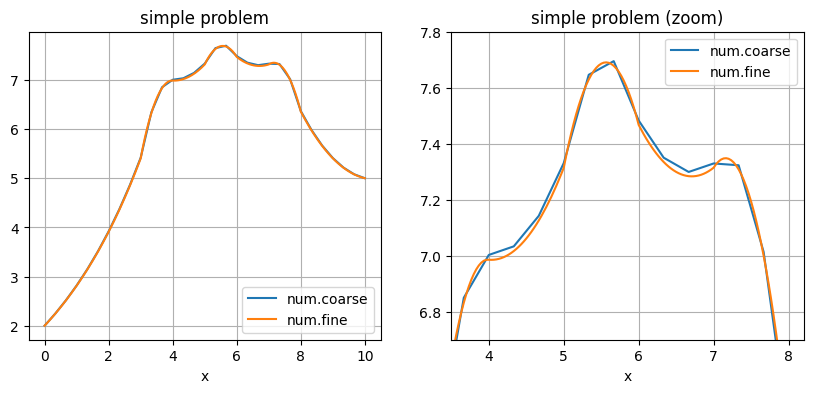

In [302]:
# create solver object
solver = FEM_solver(3,True)

# solve
A_coarse,b_coarse = solver.assemble_system(mesh_coarse,prop,bc)
solution_coarse = solver.solve_system(A_coarse,b_coarse)


# solve
A_fine,b_fine = solver.assemble_system(mesh_fine,prop,bc)
solution_fine = solver.solve_system(A_fine, b_fine)

# plots
x_coarse = np.cumsum(mesh_coarse.dx); x_coarse = np.insert(x_coarse,0,0.)
x_fine = np.cumsum(mesh_fine.dx); x_fine = np.insert(x_fine,0,0.)

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(x_coarse,solution_coarse, label='num.coarse')
axs[0].plot(x_fine  ,solution_fine  , label='num.fine')
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('x')
axs[0].set_title('simple problem')

# zoom
axs[1].plot(x_coarse,solution_coarse, label='num.coarse')
axs[1].plot(x_fine  ,solution_fine  , label='num.fine')
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel('x')
axs[1].set_title('simple problem (zoom)')
axs[1].set_xlim([3.5,8.2])
axs[1].set_ylim([6.7,7.8])
plt.show()

Example 2

In [303]:
D = np.array([2.])
sigma = np.array([0.])
q = np.array([0.])

prop = {}
prop['src']  = q
prop['D']    = D
prop['sigma'] = sigma

bc = {}
bc['xmin']={'type':'robin','value':1.}
bc['xmax']={'type':'robin','value':0.}


# pick 1 region
imat_geo = [0]

widths = np.array([10.])

nrefs_coarse =  3*np.ones(len(imat_geo),dtype=int)
nrefs_fine   = 30*np.ones(len(imat_geo),dtype=int)

In [304]:
mesh_coarse = MESH(imat_geo, imat_geo, widths, nrefs_coarse,False)
mesh_fine   = MESH(imat_geo, imat_geo, widths, nrefs_fine,False)

INFO: Info logger has been turned on.
INFO: Info logger has been turned on.


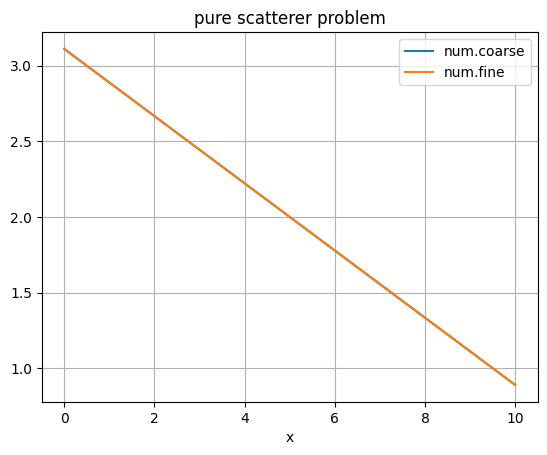

In [305]:
# create solver object
solver = FEM_solver(3,False)

# solve
A_coarse,b_coarse = solver.assemble_system(mesh_coarse,prop,bc)
solution_coarse = solver.solve_system(A_coarse,b_coarse)

# solve
A_fine,b_fine = solver.assemble_system(mesh_fine,prop,bc)
solution_fine = solver.solve_system(A_fine, b_fine)

# plots
x_coarse = np.cumsum(mesh_coarse.dx); x_coarse = np.insert(x_coarse,0,0.)
x_fine = np.cumsum(mesh_fine.dx); x_fine = np.insert(x_fine,0,0.)

plt.figure()
plt.plot(x_coarse,solution_coarse, label='num.coarse')
plt.plot(x_fine  ,solution_fine  , label='num.fine')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.title('pure scatterer problem')
plt.show()

Example 3

In [306]:
D = np.array([2.])
sigma = np.array([0.1])
q = np.array([1.])

prop = {}
prop['src']  = q
prop['D']    = D
prop['sigma'] = sigma

bc = {}
bc['xmin']={'type':'neumann','value':-1.}
bc['xmax']={'type':'neumann','value':0.}


# pick 1 region
imat_geo = [0]

widths = np.array([10.])

nrefs_coarse =  5*np.ones(len(imat_geo),dtype=int)
nrefs_fine   = 50*np.ones(len(imat_geo),dtype=int)

In [307]:
mesh_coarse = MESH(imat_geo, imat_geo, widths, nrefs_coarse,False)
mesh_fine   = MESH(imat_geo, imat_geo, widths, nrefs_fine,False)

INFO: Info logger has been turned on.
INFO: Info logger has been turned on.


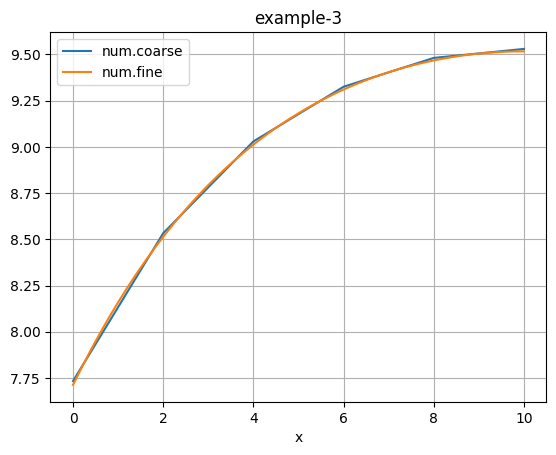

In [308]:
# create solver object
solver = FEM_solver(3,False)

# solve
A_coarse,b_coarse = solver.assemble_system(mesh_coarse,prop,bc)
solution_coarse = solver.solve_system(A_coarse,b_coarse)

# solve
A_fine,b_fine = solver.assemble_system(mesh_fine,prop,bc)
solution_fine = solver.solve_system(A_fine, b_fine)

# plots
x_coarse = np.cumsum(mesh_coarse.dx); x_coarse = np.insert(x_coarse,0,0.)
x_fine = np.cumsum(mesh_fine.dx); x_fine = np.insert(x_fine,0,0.)

plt.figure()
plt.plot(x_coarse,solution_coarse, label='num.coarse')
plt.plot(x_fine  ,solution_fine  , label='num.fine')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.title('example-3')
plt.show()